## <center>Simple 2-state analysis with RMSD-based transition interfaces</center>

##### MUST SHARE KERNEL WITH NOTEBOOK `00-load-data.ipynb`

#### Show Results after calibration of Rate-calculation parameters

------------------------

Note that the forwards and backwards rates of observed transitions (ie folding and unfolding observations, NOT chemical rates) become equal when the trajectory is long enough. This is becomes obvious considering each forward can only come after a backwards, etc.

- thus we do not need to look at both observations to determine overall convergence

<center>Specify parameters for best calculation after step 11-calibrate</center>

In [36]:
bestresinsteps = 100
interface_spec = "4.1"
bestone = match_keys(
    match_keys(list(the_dtrajs), "%d_" % bestresinsteps), interface_spec
)[0]

#### Examination of Rate results from the different tested parameters for transition identification
---------------

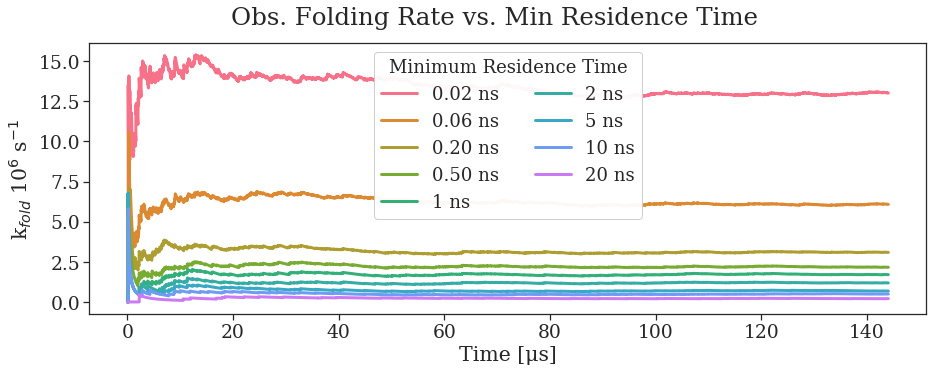

In [37]:
plt.close()
plt.figure(figsize=(15, 5))

basically_same_after = 1200000

colorcycle = iter(seaborn.color_palette("husl", n_colors=10))

# Track the ones we will show for later
lastsum = -1
showthese = list()

for i, key in enumerate(longtraj_2states):

    n_steps_inthisone = int(key.split("min_residence-")[-1].split("_interfaces")[0])

    _sum = np.sum(
        observed_rates[key]["backwards"][: basically_same_after // incr_length]
    )

    if not _sum:
        continue

    elif abs(_sum - lastsum) < 1e-4:
        continue

    else:
        showthese.append((i, key))
        lastsum = _sum

    seaborn.lineplot(
        # x=observed_rates[label_timesteps]["OpenMM"],
        # y=observed_rates[key]["forwards"],
        x=observed_rates[label_timesteps][label_longtraj],
        y=observed_rates[key]["backwards"],
        # Hidden residence time calculation depends on
        # timestep, 20 picoseconds for OpenMM
        label="%.2f ns" % (0.02 * int(splitsteps(key)))
        if int(splitsteps(key)) < 49
        else "%d ns" % (0.02 * int(splitsteps(key))),
        color=next(colorcycle),
        linewidth=3,
        linestyle=":",  # "-" if n_steps_inthisone==bestresinsteps else ":",
    )

legend = plt.legend(
    fontsize="18",
    ncol=2,
    title="Minimum Residence Time",
    loc="upper center",
    framealpha=0.95,
)

legend.get_title().set_fontsize("18")
plt.suptitle("Obs. Folding Rate vs. Min Residence Time")
plt.xlabel(label_timesteps)
# plt.ylabel("s$^{-1}$")
plt.ylabel("k$_{fold}$ 10$^6$ s$^{-1}$")
plt.savefig(
    analysis_directory / ("folding-observedrate-longtraj" "-rescalibration.png"),
    dpi=600,
)

#### Convergence of estimated rate with increasing MD time
----------------

<center>From a selected part of the trajectory (to observe convergence timescale)</center>

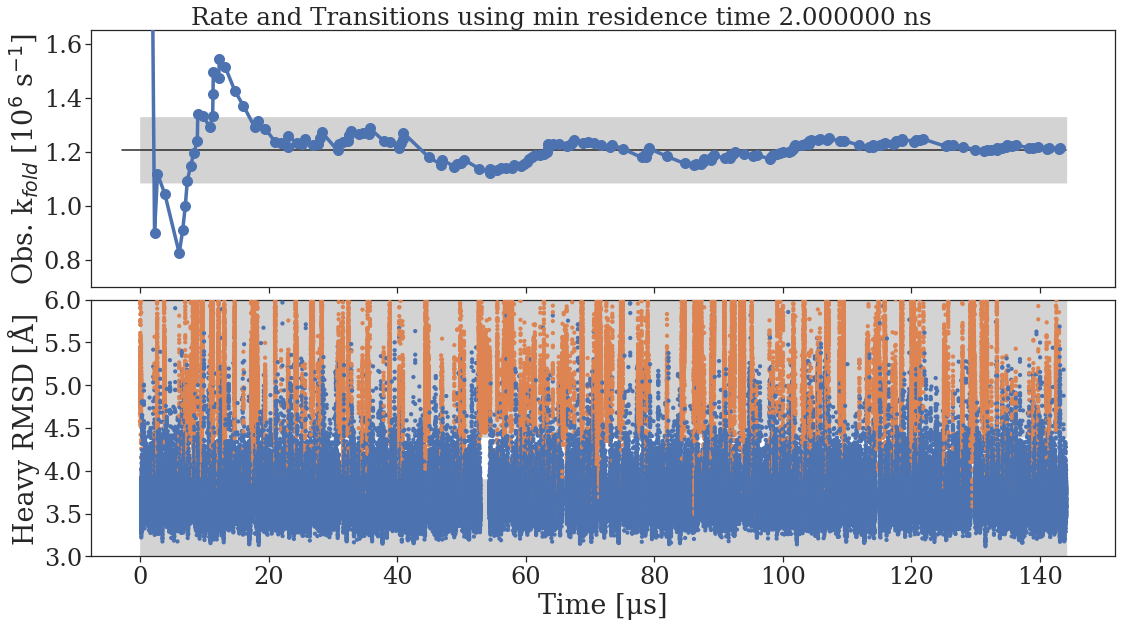

In [38]:
plt.close()
fig, axes = plt.subplots(2, 1, figsize=(16, 9), sharex=True)

n_frames = -1
interfacecolor = "lightgrey"
colorcycle = seaborn.color_palette("husl", n_colors=8)
escapecoxlor = [min(1, np.sum(c)) for c in zip(colorcycle[0], (0.0, -0.09, -0.09, 0))]
entercolor = [min(1, np.sum(c)) for c in zip(colorcycle[6], (-0.15, -0.15, -0.15, 0))]

ratesdates = [_index_to_time(tt) for tt in transition_data[bestone][0][1][0]]

axes[0].plot(
    ratesdates,
    [(i + 1) / rd for i, rd in enumerate(ratesdates)],
    linewidth=3.5,
    # ax=axes[0],
    zorder=10,
    markersize=10,
    marker="o",
)

plt.xlabel(label_timesteps)

# Timeseries Values
seaborn.scatterplot(
    x=traj_rmsd_df[label_timesteps][::10],
    y=traj_rmsd_df[label_heavies][::10],
    # color=timeseriescolor,
    hue=the_dtrajs[bestone][::10],
    ax=axes[1],
    zorder=10,
    linewidth=0,
    legend=False,
    size=3,
)

axes[0].set_ylabel("Obs. k$_{fold}$ [10$^6$ s$^{-1}$]", fontsize=27)
axes[1].yaxis.label.set_fontsize(27)
axes[1].xaxis.label.set_fontsize(27)

# axes[1].get_xticklabels().set_fontsize(22)
# axes[1].get_yticklabels().set_fontsize(22)
# axes[0].get_yticklabels().set_fontsize(22)

for tick in axes[1].xaxis.get_major_ticks():
    tick.label.set_fontsize(24)

for tick in axes[1].yaxis.get_major_ticks():
    tick.label.set_fontsize(24)

# axes[0].set_yticks([0, 0.5, 1., 1.5])
for tick in axes[0].yaxis.get_major_ticks():
    tick.label.set_fontsize(24)

# Plus or minus 0.2 MHz from Angswante paper
_exprateerror = 0.1
averagerate = observed_rates[bestone]["backwards"].iloc[-1]
axes[0].axhline(averagerate, 0.03, 0.952, color=(0.15, 0.15, 0.15, 1))
axes[0].fill_between(
    observed_rates[label_timesteps][label_longtraj][:],
    (1 + _exprateerror) * averagerate,
    (1 - _exprateerror) * averagerate,
    color=interfacecolor,
)

_interfaces = [shading_min] + ifcs_2state_1 + [shading_max]
#   - transition interface locations
for i in range(len(_interfaces) // 2):
    axes[1].fill_between(
        traj_rmsd_df[label_timesteps][:],
        _interfaces[2 * i],
        _interfaces[2 * i + 1],
        color=interfacecolor,
    )

axes[0].set_ylim(0.7, 1.65)
axes[1].set_ylim(3, 6)
# axes[1].set_xticks([])

plt.suptitle(
    "Rate and Transitions using min residence time %f ns" % (bestresinsteps * 0.02)
)
fig.tight_layout()
fig.subplots_adjust(hspace=0.05)

plt.savefig(
    analysis_directory
    / ("folding-observedrate_RMSD_statecolor" "-stacked-longtraj-best-selected.png"),
    dpi=600,
)

<center>From full trajectory</center>

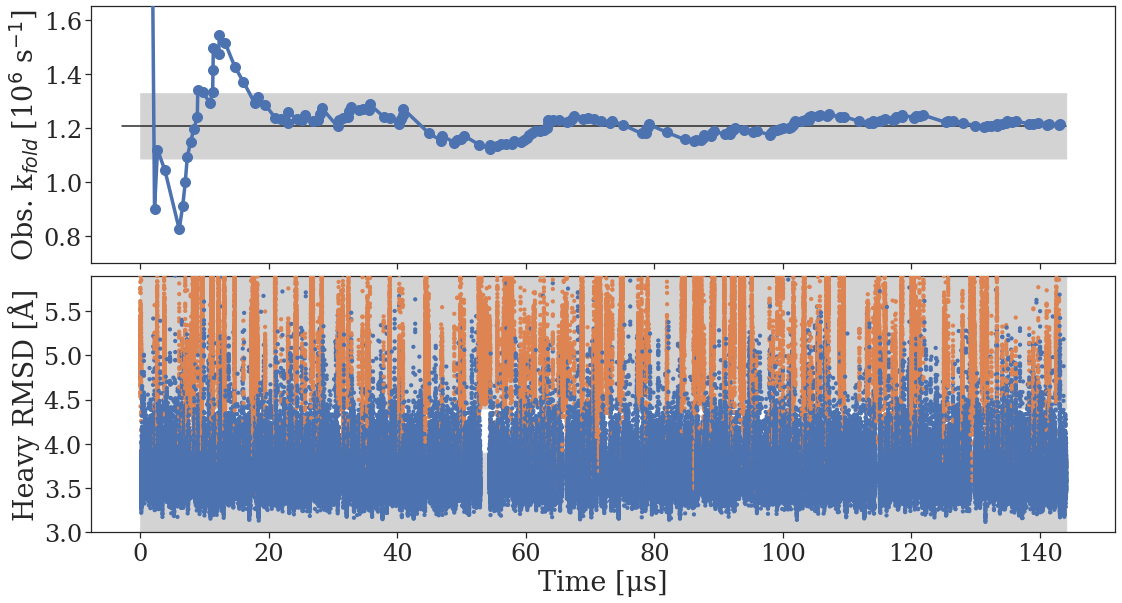

In [39]:
plt.close()
fig, axes = plt.subplots(2, 1, figsize=(16, 9), sharex=True)

n_frames = -1
interfacecolor = "lightgrey"
colorcycle = seaborn.color_palette("husl", n_colors=8)
escapecoxlor = [min(1, np.sum(c)) for c in zip(colorcycle[0], (0.0, -0.09, -0.09, 0))]
entercolor = [min(1, np.sum(c)) for c in zip(colorcycle[6], (-0.15, -0.15, -0.15, 0))]

ratesdates = [_index_to_time(tt) for tt in transition_data[bestone][0][1][0]]

axes[0].plot(
    ratesdates,
    [(i + 1) / rd for i, rd in enumerate(ratesdates)],
    linewidth=3.5,
    # ax=axes[0],
    zorder=10,
    markersize=10,
    marker="o",
)

plt.xlabel(label_timesteps)

# Timeseries Values
seaborn.scatterplot(
    x=traj_rmsd_df[label_timesteps][::10],
    y=traj_rmsd_df[label_heavies][::10],
    # color=timeseriescolor,
    hue=the_dtrajs[bestone][::10],
    ax=axes[1],
    zorder=10,
    linewidth=0,
    legend=False,
    size=3,
)

axes[0].set_ylabel("Obs. k$_{fold}$ [10$^6$ s$^{-1}$]", fontsize=27)
axes[1].yaxis.label.set_fontsize(27)
axes[1].xaxis.label.set_fontsize(27)

# axes[1].get_xticklabels().set_fontsize(22)
# axes[1].get_yticklabels().set_fontsize(22)
# axes[0].get_yticklabels().set_fontsize(22)

for tick in axes[1].xaxis.get_major_ticks():
    tick.label.set_fontsize(24)

for tick in axes[1].yaxis.get_major_ticks():
    tick.label.set_fontsize(24)

# axes[0].set_yticks([0, 0.5, 1., 1.5])
for tick in axes[0].yaxis.get_major_ticks():
    tick.label.set_fontsize(24)

# Plus or minus 0.2 MHz from Angswante paper
_exprateerror = 0.1
averagerate = observed_rates[bestone]["backwards"].iloc[-1]
axes[0].axhline(averagerate, 0.03, 0.952, color=(0.15, 0.15, 0.15, 1))
axes[0].fill_between(
    observed_rates[label_timesteps][label_longtraj][:],
    (1 + _exprateerror) * averagerate,
    (1 - _exprateerror) * averagerate,
    color=interfacecolor,
)

_interfaces = [shading_min] + ifcs_2state_1 + [shading_max]
#   - transition interface locations
for i in range(len(_interfaces) // 2):
    axes[1].fill_between(
        traj_rmsd_df[label_timesteps][:],
        _interfaces[2 * i],
        _interfaces[2 * i + 1],
        color=interfacecolor,
    )

axes[0].set_ylim(0.7, 1.65)
axes[1].set_ylim(3, 5.9)
# axes[1].set_xticks([])

fig.tight_layout()
fig.subplots_adjust(hspace=0.05)
plt.savefig(
    analysis_directory
    / ("folding-observedrate_RMSD_statecolor" "-stacked-longtraj-best-full.png"),
    dpi=600,
)

--------
--------

In [40]:
print(colorama.Back.LIGHTBLACK_EX + colorama.Fore.BLUE + "  DONE LOADING DATA  ")

  DONE LOADING DATA  


------------

------------

------------

------------